In [1]:
import os
import shutil
import zipfile
import tensorflow as tf

2024-05-22 04:03:43.049335: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 04:03:44.944517: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 04:03:44.947687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 04:03:49.807679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Function to rename files in a folder
def rename_files(folder_path, label):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter to include only .gif files
    gif_files = [f for f in files if f.endswith('.gif')]

    # Rename each file
    for index, filename in enumerate(gif_files):
        # Construct new file name
        new_name = f"{label}_{index + 1}.gif"

        # Get full path for the old and new file names
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_name)

        # Rename the file
        os.rename(old_file, new_file)
    print(f"Renamed files in {folder_path} to {label}_#.gif")

In [3]:
# Extract the zip file
zip_file_path = '/dgxa_home/se20ucam045/gif_data.zip'
extracted_folder = 'gif_data_extracted.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

In [4]:
# Paths to the extracted folders
sad_folder = os.path.join(extracted_folder, 'Sad_2')
happy_folder = os.path.join(extracted_folder, 'Happy_3')
sarcasm_folder = os.path.join(extracted_folder, 'Sarcasm_4')

In [5]:
# Rename the files in each folder
rename_files(sad_folder, 'sad')
rename_files(happy_folder, 'happy')
rename_files(sarcasm_folder, 'sarcasm')

Renamed files in gif_data_extracted.zip/Sad_2 to sad_#.gif
Renamed files in gif_data_extracted.zip/Happy_3 to happy_#.gif
Renamed files in gif_data_extracted.zip/Sarcasm_4 to sarcasm_#.gif


In [6]:
# Load and preprocess data without data augmentation
def load_data(data_dir, image_size, batch_size, validation_split=0.35):
    # Load and preprocess training data with validation split
    train_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='training',
        seed=123
    )

    # Load and preprocess validation data with validation split
    val_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='validation',
        seed=123
    )

    return train_data, val_data

In [7]:
# Set parameters (gloabl for all algo)
data_dir = '/dgxa_home/se20ucam045/gif_data_extracted.zip'
image_size = (224, 224)
batch_size = 32
num_classes = 3

In [8]:
# Calculate class weights to handle class imbalance
def calculate_class_weights(data_dir):
    # Count the number of samples in each class
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        class_counts[class_name] = len(os.listdir(class_path))


    # Calculate class weights
    total_samples = sum(class_counts.values())
    class_weights = {}
    for class_name, count in class_counts.items():
        class_weights[class_name] = total_samples / (len(class_counts) * count)

    return class_weights

In [9]:
# Load the data (global for all algo)
train_data, val_data = load_data(data_dir, image_size, batch_size)

Found 5448 files belonging to 3 classes.
Using 3542 files for training.


2024-05-22 04:09:59.897158: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-22 04:09:59.897196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: dgxb
2024-05-22 04:09:59.897201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: dgxb
2024-05-22 04:09:59.897331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.161.3
2024-05-22 04:09:59.897345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.161.3
2024-05-22 04:09:59.897349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 470.161.3


Found 5448 files belonging to 3 classes.
Using 1906 files for validation.


In [10]:
calculate_class_weights(data_dir)

{'Happy_3': 0.9293756397134084, 'Sad_2': 4.54, 'Sarcasm_4': 0.5869424692954105}

vgg

In [11]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16


In [12]:
# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

58889256/58889256 [==============================] - 4s 0us/step


In [13]:
# Add custom classification layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

In [14]:
#Model to be trained
model_vgg = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [15]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# train with dgx----------------------------------------------------------------
history = model_vgg.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
111/111 [==============================] - 562s 5s/step - loss: 2.0673 - accuracy: 0.5054 - val_loss: 0.9781 - val_accuracy: 0.5341
Epoch 2/10
111/111 [==============================] - 543s 5s/step - loss: 0.9032 - accuracy: 0.5621 - val_loss: 0.9327 - val_accuracy: 0.5577
Epoch 3/10
111/111 [==============================] - 535s 5s/step - loss: 0.8520 - accuracy: 0.5977 - val_loss: 0.9449 - val_accuracy: 0.5651
Epoch 4/10
111/111 [==============================] - 537s 5s/step - loss: 0.8238 - accuracy: 0.6143 - val_loss: 0.9513 - val_accuracy: 0.5462
Epoch 5/10
111/111 [==============================] - 537s 5s/step - loss: 0.8068 - accuracy: 0.6228 - val_loss: 0.9449 - val_accuracy: 0.5708
Epoch 6/10
111/111 [==============================] - 535s 5s/step - loss: 0.7784 - accuracy: 0.6318 - val_loss: 0.9720 - val_accuracy: 0.5672
Epoch 7/10
111/111 [==============================] - 534s 5s/step - loss: 0.7507 - accuracy: 0.6516 - val_loss: 0.9629 - val_accuracy: 0.5640

In [18]:
# Evaluate the model on the training data
print("Evaluating the model...")
train_loss, train_accuracy = model_vgg.evaluate(train_data, verbose=0)
print(f"Training loss for vgg: {train_loss}")
print(f"Training accuracy for vgg: {train_accuracy}")

# Evaluate the model on the validation data
print("Evaluating the model...")
Val_loss, val_acc = model_vgg.evaluate(val_data, verbose=0)
print(f"val loss for vgg: {Val_loss}")
print(f"val accuracy for vgg: {val_acc}")

Evaluating the model...
Training loss for vgg: 0.6052440404891968
Training accuracy for vgg: 0.7168266773223877
Evaluating the model...
val loss for vgg: 1.0177265405654907
val accuracy for vgg: 0.5440713763237


In [19]:
y_pred = model_vgg.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)

60/60 [==============================] - 213s 3s/step


In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [25]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(fpr)
print(tpr)
print(roc_auc)

{0: array([0.00000000e+00, 8.19000819e-04, 8.19000819e-04, 3.27600328e-03,
       3.27600328e-03, 4.09500410e-03, 4.09500410e-03, 7.37100737e-03,
       9.00900901e-03, 1.22850123e-02, 1.22850123e-02, 1.31040131e-02,
       1.31040131e-02, 2.04750205e-02, 2.04750205e-02, 2.12940213e-02,
       2.12940213e-02, 2.37510238e-02, 2.37510238e-02, 2.45700246e-02,
       2.45700246e-02, 2.62080262e-02, 2.62080262e-02, 2.70270270e-02,
       2.70270270e-02, 2.94840295e-02, 2.94840295e-02, 3.76740377e-02,
       3.76740377e-02, 3.93120393e-02, 3.93120393e-02, 4.09500410e-02,
       4.09500410e-02, 4.25880426e-02, 4.25880426e-02, 4.34070434e-02,
       4.34070434e-02, 4.42260442e-02, 4.42260442e-02, 4.75020475e-02,
       4.91400491e-02, 4.99590500e-02, 5.07780508e-02, 5.07780508e-02,
       5.40540541e-02, 5.40540541e-02, 5.56920557e-02, 5.73300573e-02,
       5.73300573e-02, 5.81490581e-02, 5.81490581e-02, 6.06060606e-02,
       6.06060606e-02, 6.22440622e-02, 6.22440622e-02, 6.30630631e-02,
  

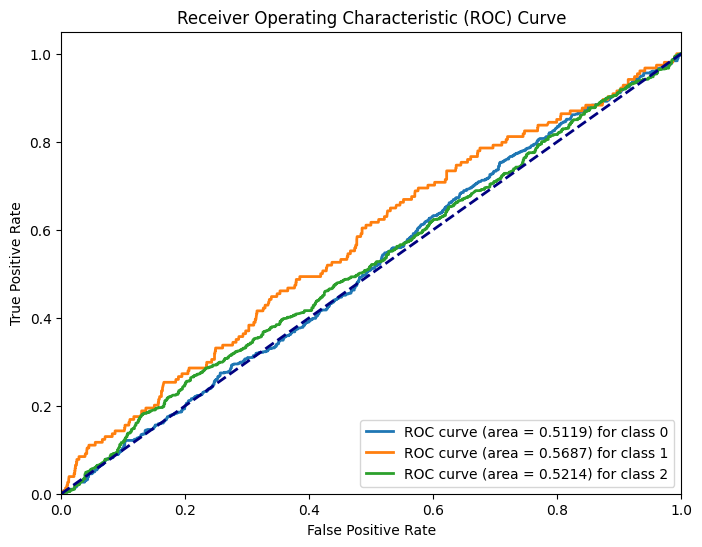

In [26]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.4f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()